# Какво ще правя?

Харесах си [едно състезание в kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Става въпрос за класифициране на текст и по-точно на "токсични коментари".

От описанието на състезанието, токсичните коментари имат няколко характеристики (toxic, severe_toxic, obscene, threat, insult, identity_hate), а целта накрая е да се даде оценка на характеристиките на всеки коментар. Коментарите са от статии в Wikipedia и са label-нати от доброволци.

*П.П. Може да има и малко по-остра реч в тях.*


# Да започваме същинската част


Първо ще трябва да си направя някаквъ базов модел. Към момента в състезанието високите оценки са от сорта на `98.67`, така че гоним базов модел със сравнително висока оценка.

За целта смятам да използвам някаква вариация на Naive Bayes - все пак ще работим с текст.

Да видим все пак как изглежда данните.

In [1]:
import pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('./data/train.csv.zip', index_col=['id'])
test_data = pd.read_csv('./data/test.csv.zip', index_col=['id'])

sample = train_data.sample(15)
sample

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
806fea2c9bdddf3b,Court records are by definition both accurate ...,0,0,0,0,0,0
b66c16a90ac8f965,"""\n\n Recent page moves (see also: unresolved ...",0,0,0,0,0,0
ebbf00e1ebe86f7e,douch bag \n\nThats you.,1,0,0,0,0,0
c39553a9b227b554,! And I'm not a sock puppet of Gogo Dodo But s...,0,0,0,0,0,0
1feb0389279d02ce,"I WAS NOT TROLLING, I WAS SUGGESTING THAT HE W...",1,0,0,0,0,0
9ec1390d1031ecc1,We have tons of research to back it up. Just l...,0,0,0,0,0,0
c4ab8ff9d664b5a2,"Throughout this season of Full House, Michelle...",0,0,0,0,0,0
9807839c92c15175,"""The Bulgarians were never tengriists, neither...",0,0,0,0,0,0
c325cb0060687864,"""\n\nUnblock: South Korean population update. ...",0,0,0,0,0,0


Ето и първия пример в цялото си изящество.

In [3]:
print(sample['comment_text'][0])

Court records are by definition both accurate (people are sworn in) and significant (insignificant facts are stricken).  If this article is to include anything from the Eichenwald article, it must also contain any relevant information concerning the motivations and therefore the accuracy of Eichenwald's writing.  If the court records (which Eichenwald incidentally strove for months to keep sealed) are not considered significant, then everything in this article sourced from Eichenwald's exposé must be removed.


In [4]:
for text in sample['comment_text']:
    print(len(text))

514
3511
22
65
57
120
166
1038
179
31
270
820
116
696
447


Както се вижда, дори и в тази малка извадка, дължината на текстовете варира много. Да видим как точно изглежда това на графика.

In [5]:
comments = train_data['comment_text'].str.len()
comments.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

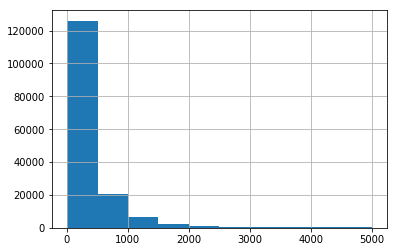

In [6]:
comments.hist()

Вижда се, че почти всички коментари са с дължина около 0-1000, има малко до 2000 и след това са по-скоро аномалии (outlyer-и).

В малката извадка, която имаме, се вижда, че има коментар, който не е label-нат - всичките му колкони са 0. Ще направим нов label `unknown` и ще го сложим на подобни коментари.

In [7]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data['unknown'] = 1 - train_data[label_cols].max(axis=1)

label_cols.append('unknown')

train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,unknown
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


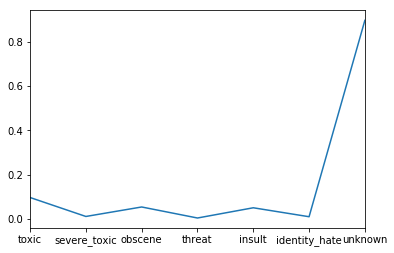

In [11]:
train_data[label_cols].mean().plot()

Преди да започнем с имплементацията на каквото и да било, ще си направя възможно най-базов модел. Ще използвам `CountVectorizer` + `MonomialNB` за него без да си играя да нагласям каквито и да било хиперпараметри, за да мога да добия някаква базова представа.

За целта на нашите задачи, ще използваме `MultiOutputClassifier`, тъй като предвиждаме няколко класа.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier


pipeline = Pipeline([('vec', CountVectorizer()), ('clf', MultiOutputClassifier(MultinomialNB()))])
cross_val_score(pipeline, train_data.comment_text, train_data[label_cols], cv=5, n_jobs=2)

array([0.90067366, 0.9010779 , 0.90164191, 0.90098389, 0.90270728])

![Not bad actually](https://media1.giphy.com/media/11wqqxRxm0uoY8/giphy.gif)

### В началото казах, че ще ползваме някаква форма на Naive Bayes

В един от кърналите в състезанието се натъкнах на много интересен [paper](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf), работа на Sida Wang и Chris Maning. В него се говори за NBSVM, който ще използвам за базов модел.

Накратко, те откриват релация между Monomial Naive Bayes и Support Vector Machine. След проведени експерименти, откриват, че MNB се справя доста добре с по-кратки текстове или т.нар. snippets, а SVM е по-добър в пълни по дължина ревюта.

Това, като се замисля, е доста логично - ако подадеш на NB малки откази, където има псувни или думи, които ясно изразяват омраза, той лесно ще ги класифицира, като `toxic`, докато с по-пълни текстове ще има повече шум.

Комбинацията NBSVM показва много добри резултати както със snippet-и, така и с пълни текстове, взимайки най-доброто от двата алгоритъма.

Нещо, което правят, за да подобрят своите експерименти, е използването и на биграми, което смятам да опитам и аз.

Според статията, с NBSVM е по-добре да се използва TFIDF, вместо count vectorizer или "bag of words" - винаги давало по-добри резултати. Обаче на мен горния резултат ми хареса достатъчно, така че засега ще пробвам и с двете.

In [10]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r"'?\b[0-9A-Za-z'-]+\b'?")  # matches numbers, words and words with apostrophes

Това горното очевидно си го копирах. Ето какво прави:

>re.compile(f'...') compiles the expression([{string.punctuation}...]) into pattern objects (say, for later pattern matching or string substitutions) while the f'...' prefix causes the formatted string literal (f-string) {string.punctuation} to be evaluated at run-time. Note that string.punctuation is a readymade-string of common punctuation marks.

>Later re_tok.sub(r' \1 ', s) finds all the resulting matching-punctuations and adds a prefix and suffix of white-space to those matching patterns. Lastly, split() call tokenizes resulting string into an array of individual words and punctuation marks.

Ето пример за нагледно обяснение.

In [11]:
example = tokenizer.tokenize(sample['comment_text'][0])
example

['User',
 'Rohedin',
 're',
 'your',
 'warning',
 'Uh',
 'you',
 'sure',
 'about',
 'that',
 'I',
 'see',
 'two',
 'edits',
 'here',
 'and',
 'here',
 'Looks',
 'OK',
 'to',
 'me',
 'or',
 'am',
 'I',
 'missing',
 'something',
 'Cheers',
 'TFOWR']

Сега да махнем стоп думите.

In [12]:
# import nltk
# nltk.download('stopwords')

In [13]:
from nltk.corpus import stopwords


def remove_stop_words(tokens):
    english_stop_words = set(stopwords.words('english'))

    return [token for token in tokens if token not in english_stop_words]

remove_stop_words(example)

['User',
 'Rohedin',
 'warning',
 'Uh',
 'sure',
 'I',
 'see',
 'two',
 'edits',
 'Looks',
 'OK',
 'I',
 'missing',
 'something',
 'Cheers',
 'TFOWR']

Добре, близо сме. Ще изкарам една функция, за да тестваме дали имаме желания ефект. Вместо да използвам функцията, ще използваме аргументите на `CountVectorizer` и `TfidfVectorizer`.

In [14]:
def handle_tokenization(text):
    tokens = tokenizer.tokenize(text)
    
    tokens_without_stop_words = remove_stop_words(tokens)
    
    return tokens_without_stop_words


handle_tokenization(sample['comment_text'][0])

['User',
 'Rohedin',
 'warning',
 'Uh',
 'sure',
 'I',
 'see',
 'two',
 'edits',
 'Looks',
 'OK',
 'I',
 'missing',
 'something',
 'Cheers',
 'TFOWR']

Готови сме! Сега е време да си направим матрицата с думите. Ще използвам униграми и биграми, както пишеше в paper-a. За класификатори ще се пробвам с:
- Мultinomial NB
- LinearSVC
- SVC
- RandomForest

Ще сравня резултатите от тях с NBSVM, който ще напишем сега.

In [37]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse


class NBSVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [10]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Понеже чаках над 2 часа с RandomForest, ще го пусна само за 10 дървета, за да видя колко време ще ми отнеме.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier


def try_random_forest():
    import time

    start = time.time()
    pipeline = Pipeline([('vec', CountVectorizer()), ('clf', MultiOutputClassifier(RandomForestClassifier()))])
    print(cross_val_score(pipeline, train_data.comment_text, train_data[label_cols], cv=5, n_jobs=4))

    end = time.time()

    return end - start

# try_random_forest()

[ 0.89613035  0.89875917  0.89825782  0.89882183  0.89850849]


1475.0570828914642

```[ 0.89613035  0.89875917  0.89825782  0.89882183  0.89850849]
Out[18]:
1475.0570828914642```

Това е прекалено много и нямам време в момента да го чакам. Предполагам, че дори с малко увеличение на дурветата, ще даде по-добри резултати, но поради ред обстоятелства ще го оставя за по-късно.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.multioutput import MultiOutputClassifier


count_vec_params = {
    'vec__ngram_range': [(1,2)],
    'vec__lowercase': [True],
    'vec__analyzer': ['word'],
    'vec__token_pattern': [r"'?\b[0-9A-Za-z'-]+\b'?"],
    'vec__stop_words': ['english'],
}
tfidf_params = count_vec_params.copy().update({
    'vec__use_idf': [True],
    'vec__smooth_idf': [True],
    'vec__sublinear_tf': [True]
})

vec_params = {
    CountVectorizer: count_vec_params,
    TfidfVectorizer: tfidf_params
}

hyper_parameter_values = list(np.arange(0.1, 1.5, 0.2)) + list(range(2, 10, 2))

clf_params = {
    MultinomialNB: {'clf__estimator__alpha': hyper_parameter_values},
    LinearSVC: {'clf__estimator__C': hyper_parameter_values},
    SVC: {'clf__estimator__C': hyper_parameter_values}
}


results = []

for vec in vec_params.keys():
    for clf in clf_params.keys():
        print(f'{vec.__name__} + {clf.__name__}')
        params = vec_params[vec].copy()
        params.update(clf_params[clf])

        pipeline = Pipeline([
            ('vec', vec()),
            ('clf', MultiOutputClassifier(clf()))
        ])

        grid_search = GridSearchCV(
            pipeline,
            param_grid=params,
            cv=5,
            n_jobs=4,
            verbose=1
        )
        grid_search.fit(train_data.comment_text, train_data[label_cols])
        report(grid_search.cv_results_)
        
        results.append((grid_search.best_score_, grid_search.best_params_))
        
sorted(results, reverse=True, key=lambda res: res[0])

CountVectorizer + MultinomialNB
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed: 15.3min finished


Model with rank: 1
Mean validation score: 0.908 (std: 0.001)
Parameters: {'clf__estimator__alpha': 0.50000000000000011, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english', 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?"}

Model with rank: 2
Mean validation score: 0.907 (std: 0.001)
Parameters: {'clf__estimator__alpha': 0.70000000000000007, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english', 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?"}

Model with rank: 3
Mean validation score: 0.907 (std: 0.001)
Parameters: {'clf__estimator__alpha': 0.30000000000000004, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english', 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?"}

Model with rank: 4
Mean validation score: 0.907 (std: 0.001)
Parameters: {'clf__estimator__alpha': 0.90000000000000013, 'vec__analyzer': 'word', 'vec__lowercase': Tru

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 55.8min
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed: 77.4min finished


Model with rank: 1
Mean validation score: 0.915 (std: 0.001)
Parameters: {'clf__estimator__C': 0.10000000000000001, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english', 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?"}

Model with rank: 2
Mean validation score: 0.914 (std: 0.002)
Parameters: {'clf__estimator__C': 0.30000000000000004, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english', 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?"}

Model with rank: 3
Mean validation score: 0.913 (std: 0.002)
Parameters: {'clf__estimator__C': 0.50000000000000011, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english', 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?"}

Model with rank: 4
Mean validation score: 0.913 (std: 0.002)
Parameters: {'clf__estimator__C': 0.70000000000000007, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_r

KeyboardInterrupt: 

`CountVectorizer` + `SVC` не намери решение повече 8 часа... Засега ще се спра на горните резултати. Ще изпробваме и какво ще се получи, с TFIDF. Според статията, трябва да имаме подобрение.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier


# pipeline = Pipeline([('vec', CountVectorizer()), ('clf', MultiOutputClassifier(MultinomialNB()))])
# print(cross_val_score(pipeline, train_data.comment_text, train_data[label_cols], cv=5, n_jobs=4))

hyper_parameter_values = list(np.arange(0.1, 1.5, 0.2)) + list(range(2, 10, 2))

params = {
    'vec__ngram_range': [(1,2)],
    'vec__lowercase': [True],
    'vec__analyzer': ['word'],
    'vec__token_pattern': [r"'?\b[0-9A-Za-z'-]+\b'?"],
    'vec__stop_words': ['english'],
    'vec__use_idf': [True],
    'vec__smooth_idf': [True],
    'vec__sublinear_tf': [True]
}

params.update({'clf__estimator__alpha': hyper_parameter_values})

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', MultiOutputClassifier(MultinomialNB()))
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=5,
    n_jobs=4,
)
grid_search.fit(train_data.comment_text, train_data[label_cols])
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.904 (std: 0.001)
Parameters: {'clf__estimator__alpha': 0.1, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?", 'vec__use_idf': True}

Model with rank: 2
Mean validation score: 0.900 (std: 0.001)
Parameters: {'clf__estimator__alpha': 0.30000000000000004, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?", 'vec__use_idf': True}

Model with rank: 3
Mean validation score: 0.899 (std: 0.001)
Parameters: {'clf__estimator__alpha': 0.5000000000000001, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[0-9A-

Тука виждам, че имам значително подобрение към 0.1, което ми се явява граница. Прабвах и с по-малки стойности (0.01 и 0.001), но нямаше значително подобрение.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

params = {
    'vec__ngram_range': [(1,2)],
    'vec__lowercase': [True],
    'vec__analyzer': ['word'],
    'vec__token_pattern': [r"'?\b[0-9A-Za-z'-]+\b'?"],
    'vec__stop_words': ['english'],
    'vec__use_idf': [True],
    'vec__smooth_idf': [True],
    'vec__sublinear_tf': [True]
}

hyper_parameter_values = list(np.arange(0.1, 1.5, 0.2)) + list(range(2, 10, 2))

params.update({'clf__estimator__C': hyper_parameter_values})

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', MultiOutputClassifier(LinearSVC()))
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=5,
    n_jobs=4,
    verbose=1
)
grid_search.fit(train_data.comment_text, train_data[label_cols])
report(grid_search.cv_results_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 16.5min
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed: 24.3min finished


Model with rank: 1
Mean validation score: 0.920 (std: 0.001)
Parameters: {'clf__estimator__C': 0.30000000000000004, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?", 'vec__use_idf': True}

Model with rank: 2
Mean validation score: 0.920 (std: 0.001)
Parameters: {'clf__estimator__C': 0.50000000000000011, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?", 'vec__use_idf': True}

Model with rank: 3
Mean validation score: 0.919 (std: 0.001)
Parameters: {'clf__estimator__C': 0.70000000000000007, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[

Естествено, с последния вариант имаме победител. Докато чаках резултатите, се сетих, че не взимам под внимание нещо, което може да подобри модела ми. regex-a, който използваме за токенизация, в моменра хваща само думи (и такива с апострофи). Когато хората пишат токсични коментари, те често използват **последователности от препинателни знаци**. Например `.........`, `!?!?!?!!` или различни емотиконки.

In [31]:
from nltk.tokenize import RegexpTokenizer
import string

tokenizer = RegexpTokenizer(rf"'?\b[0-9A-Za-z'-]+\b'?|[{string.punctuation}]+")
test_str = train_data.sample(1)['comment_text'][0]
print(test_str)
tokenizer.tokenize(test_str)

vanished article question 

hi! i'm new here and i wanna ask you a question, there was a long article here yesterday Kinkeshi but i checked it today and the article has just disappeared!! do you know what happened to it? thanks! )


['vanished',
 'article',
 'question',
 'hi',
 '!',
 "i'm",
 'new',
 'here',
 'and',
 'i',
 'wanna',
 'ask',
 'you',
 'a',
 'question',
 ',',
 'there',
 'was',
 'a',
 'long',
 'article',
 'here',
 'yesterday',
 'Kinkeshi',
 'but',
 'i',
 'checked',
 'it',
 'today',
 'and',
 'the',
 'article',
 'has',
 'just',
 'disappeared',
 '!!',
 'do',
 'you',
 'know',
 'what',
 'happened',
 'to',
 'it',
 '?',
 'thanks',
 '!',
 ')']

**Перфектно!** Ще пробвам последния вариант, за да видим дали ще имаме по-добър резултат.

*f-strings <3*

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

params = {
    'vec__ngram_range': [(1,2)],
    'vec__lowercase': [True],
    'vec__analyzer': ['word'],
    'vec__token_pattern': [rf"'?\b[0-9A-Za-z'-]+\b'?|[{string.punctuation}]+"],
    'vec__stop_words': ['english'],
    'vec__use_idf': [True],
    'vec__smooth_idf': [True],
    'vec__sublinear_tf': [True]
}

hyper_parameter_values = list(np.arange(0.1, 1.5, 0.2)) + list(range(2, 10, 2))

params.update({'clf__estimator__C': hyper_parameter_values})

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', MultiOutputClassifier(LinearSVC()))
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=5,
    n_jobs=4,
    verbose=1
)
grid_search.fit(train_data.comment_text, train_data[label_cols])
report(grid_search.cv_results_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 21.2min
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed: 30.4min finished


Model with rank: 1
Mean validation score: 0.920 (std: 0.001)
Parameters: {'clf__estimator__C': 0.30000000000000004, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': '\'?\\b[0-9A-Za-z\'-]+\\b\'?|[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+', 'vec__use_idf': True}

Model with rank: 2
Mean validation score: 0.920 (std: 0.001)
Parameters: {'clf__estimator__C': 0.50000000000000011, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': '\'?\\b[0-9A-Za-z\'-]+\\b\'?|[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+', 'vec__use_idf': True}

Model with rank: 3
Mean validation score: 0.920 (std: 0.001)
Parameters: {'clf__estimator__C': 0.70000000000000007, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec

Добре, новият регулярен израз е доста готин, но не ни помогна особено много в този случай, а и ни забави, което е ключово за оставащото ми време. Дойде време най-после да изпробвам NBSVM. Ще го пусна с TFIDF и да видим какво ще стане.

In [38]:
import time
start = time.time()
pipeline = Pipeline([('vec', TfidfVectorizer()), ('clf', MultiOutputClassifier(NBSVMClassifier()))])
print(cross_val_score(pipeline, train_data.comment_text, train_data[label_cols], cv=5, n_jobs=4))
end = time.time()
print(end - start)

[ 0.91944227  0.92047377  0.9214138   0.92100645  0.92119446]
108.09142756462097


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

params = {
    'vec__ngram_range': [(1,2)],
    'vec__lowercase': [True],
    'vec__analyzer': ['word'],
    'vec__token_pattern': [r"'?\b[0-9A-Za-z'-]+\b'?"],
    'vec__stop_words': ['english'],
    'vec__use_idf': [True],
    'vec__smooth_idf': [True],
    'vec__sublinear_tf': [True]
}

hyper_parameter_values = list(np.arange(0.1, 1.5, 0.2)) + list(range(2, 10, 2))

params.update({'clf__estimator__C': hyper_parameter_values})

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', MultiOutputClassifier(NBSVMClassifier()))
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=5,
    n_jobs=4,
    verbose=1
)
grid_search.fit(train_data.comment_text, train_data[label_cols])
report(grid_search.cv_results_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 46.4min
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed: 62.5min finished


Model with rank: 1
Mean validation score: 0.920 (std: 0.001)
Parameters: {'clf__estimator__C': 0.90000000000000013, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?", 'vec__use_idf': True}

Model with rank: 2
Mean validation score: 0.919 (std: 0.001)
Parameters: {'clf__estimator__C': 0.70000000000000007, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[0-9A-Za-z'-]+\\b'?", 'vec__use_idf': True}

Model with rank: 3
Mean validation score: 0.919 (std: 0.001)
Parameters: {'clf__estimator__C': 0.50000000000000011, 'vec__analyzer': 'word', 'vec__lowercase': True, 'vec__ngram_range': (1, 2), 'vec__smooth_idf': True, 'vec__stop_words': 'english', 'vec__sublinear_tf': True, 'vec__token_pattern': "'?\\b[

За жалост този модел не се справи по-добре от обикновената линейна SVM.

### Да пробваме какво ще излезе и ако използваме невронна мрежа

За целта ще пиша в нов notebook, тък като този стана прекалено дълъг.